# Phasor Analysis for Fluroescence Decay

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from TCSPC import *
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd

### Create instances of Phasor class objects

In [2]:
NADH = Phasor([0.75,0.25],[0.4,4])         #NADH object
#EGFP = Phasor([0.503,0.497],[3.07,2.43])   #EGFP object
mCherry  = Phasor([0.83,0.17],[1.43,2.38]) #mCherry object
sim_list = [NADH,mCherry]
sim_name = ['NADH','mCherry']

### Example use of methods in Phasor class

| Method         | Description                                                                                           | Default Values                            |
|----------------|-------------------------------------------------------------------------------------------------------|-------------------------------------------|
| `phasor_solve()` | Solve for amplitudes and lifetime with  given w array (angular frequency) and phasor array            | w = self.w, phasor = self.phasor           |
| `generate_df()`  | Generate pd.DataFrame() to store phasor decomposition results for given w array and phasor_data array | w = self.w, phasor_data = self.phasor_data |

In [3]:
mCherry.phasor_solve()

array([ 0.32309665,  0.67690335, -2.16219325, -1.25143316])

Generated dataframe can be accessed by :

In [8]:
NADH.df

,A1,A2,t1,t2,0.05,0.1,0.15,0.2
0,0.773565,0.226435,0.383344,4.011066,0.533922+0.393668j,0.335185+0.311682j,0.267018+0.260961j,0.229114+0.234194j
1,0.777003,0.222997,0.373202,4.007152,0.533774+0.393932j,0.335108+0.311228j,0.267496+0.260462j,0.229023+0.234285j
2,0.778156,0.221844,0.368662,4.002895,0.533735+0.394038j,0.334913+0.311277j,0.267488+0.261125j,0.228707+0.234603j
3,0.771441,0.228559,0.394710,4.018032,0.534813+0.393424j,0.336426+0.311589j,0.267689+0.261362j,0.229945+0.234405j
4,0.771709,0.228291,0.390714,4.014340,0.534349+0.393716j,0.335696+0.311543j,0.267133+0.261381j,0.228674+0.234692j
...,...,...,...,...,...,...,...,...
95,0.772166,0.227834,0.391965,4.025342,0.533692+0.393483j,0.335588+0.311593j,0.267179+0.260729j,0.228943+0.234455j
96,0.771442,0.228558,0.392486,4.014181,0.534671+0.393421j,0.336041+0.311786j,0.267363+0.261045j,0.229700+0.234807j
97,0.774209,0.225791,0.386481,4.021848,0.533927+0.393383j,0.335876+0.311367j,0.267750+0.260935j,0.229456+0.234639j
98,0.773249,0.226751,0.386177,4.013742,0.534177+0.393443j,0.335612+0.311203j,0.267327+0.261289j,0.229281+0.234662j


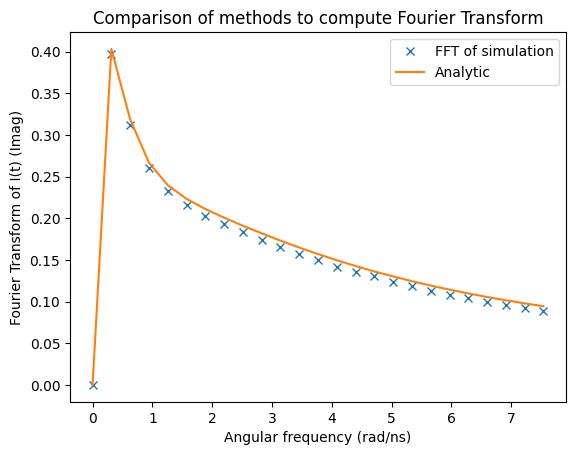

In [18]:
# W,Y = np.meshgrid(NADH.w[:190],NADH.y[15:]) 
# W,T = np.meshgrid(NADH.w[:190],NADH.t[:-15])
# #W,K = np.meshgrid(NADH.w[:190],NADH.ker)
# y_true= exp2(NADH.t,NADH.amp[0],*NADH.tau)
# #W,Y = np.meshgrid(NADH.w[:190],y_true[:]) 
# phasor = np.fft.fft(y_true)/np.sum(y_true)
# phasor.imag*=-1
# FT = lambda Y: np.sum(np.sin(T*W)*Y,axis = 0)/np.sum(NADH.y[15:]) #numerical integration for trimmed data
# plt.plot(NADH.w[:25],FT(Y)[:25],'.',label = 'Numerical Integration')
plt.plot(NADH.w[:25],NADH.phasor.imag[:25],'x',label = 'FFT of simulation')
plt.plot(NADH.w[:25],multi_exp_FT(NADH.w[:25],NADH.amp,NADH.tau).imag,label = 'Analytic')
plt.title('Comparison of methods to compute Fourier Transform')
plt.xlabel('Angular frequency (rad/ns)')
plt.ylabel('Fourier Transform of I(t) (Imag)')
plt.legend()

### Decomposition of amplitudes with known lifetimes

In [4]:
EGFP = Simulation([0.503,0.497],[3.07,2.43])

In [46]:
sim = EGFP
w = sim.w[1:len(EGFP.tau)]
W,T = np.meshgrid(sim.tau,w)
M = np.array([[1,1],1/((W*T)**2+1)[0]])
M_inv = np.linalg.inv(M)
y = np.array([1,sim.phasor.real[1]])
f = np.dot(M_inv,y)
mCherry.A_solve(list(f)+sim.tau)

array([0.48537039, 0.51462961])

In [40]:
mCherry.phasor_solve()

array([ 0.32309665,  0.67690335, -2.16219325, -1.25143316])

In [47]:
EGFP.amp

array([0.503, 0.497])

In [9]:
weights = np.sqrt(EGFP.y)[np.argmax(EGFP.y):int((15/20*380))]
result, params_opt, chi2_red, fit_report = exp_fit(exp2,EGFP.t,EGFP.y,list(EGFP.amp)+EGFP.tau,weights = weights)

In [11]:
print(fit_report)

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 275
    # variables        = 3
    chi-square         = 29.3078346
    reduced chi-square = 0.10774939
    Akaike info crit   = -609.701962
    Bayesian info crit = -598.851649
[[Variables]]
    A1:    0.00268428 +/- 0.00105979 (39.48%) (init = 0.503)
    tau1:  0.21332328 +/- 0.18985130 (89.00%) (init = 0.497)
    tau2:  2.76229581 +/- 0.00418537 (0.15%) (init = 3.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.880
    C(A1, tau1)   = 0.781
    C(tau1, tau2) = 0.623
